In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import numpy as np

In [96]:
tweets = pd.read_csv('Tweets.csv', parse_dates = ['tweet_created'])

In [97]:
tweets.shape

(14640, 15)

In [6]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null datetime64[ns, pytz.FixedOffset(-480)]
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: datetime64[ns, pytz.FixedOffset(-480)](1), float64(

In [8]:
tweets.shape

(14640, 15)

In [9]:
tweets.airline_sentiment_gold.unique()

array([nan, 'negative', 'neutral', 'positive'], dtype=object)

In [10]:
tweets.negativereason_gold.unique()

array([nan, 'Late Flight\nFlight Attendant Complaints',
       'Late Flight\nLost Luggage', 'Late Flight',
       'Customer Service Issue', "Can't Tell",
       'Cancelled Flight\nCustomer Service Issue', 'Cancelled Flight',
       'Bad Flight', 'Lost Luggage\nDamaged Luggage',
       'Late Flight\nCancelled Flight', 'Flight Attendant Complaints',
       'Customer Service Issue\nLost Luggage',
       "Customer Service Issue\nCan't Tell"], dtype=object)

Gold standard (hand-labelled by multiple humans) isn't available for many tweets. 

`airline_sentiment` and `airline_sentiment_confidence` look to have been labeled by someone who carried out a sentiment analysis, probably Cloudflower, who made the data available in 2015. 

In [11]:
tweets.tweet_location.value_counts(dropna=False, ascending = False)

NaN                             4733
Boston, MA                       157
New York, NY                     156
Washington, DC                   150
New York                         127
USA                              126
Chicago                          104
New York City                     96
Los Angeles, CA                   96
NYC                               95
San Francisco, CA                 91
San Francisco                     86
Chicago, IL                       81
Brooklyn, NY                      66
Los Angeles                       64
Austin, TX                        64
Washington, D.C.                  63
Boston                            62
Dallas, TX                        54
Washington DC                     53
Nashville, TN                     45
NY                                42
Texas                             42
San Diego                         38
Philadelphia, PA                  38
Denver, CO                        37
Houston, TX                       35
S

`tweet_location` could be useful but needs to be post-processed. Considerations here: 
* Users can clearly put in their location themselves: "A tiny place in the universe", "between Warsaw and London". Sometimes that's not very useful (as in the former), sometimes it is useful (latter). 
* We need a standard format for location: physical location (eg airport), city, state, country. 
* Some people might be putting their itineraries in the location: eg, "Phoenix, AZ // NJ", "Olympia, WA  ✈ Charleston, SC" 
* feature engineering needed: international flight vs US domestic 
* For NaN locations, it might be possible to backfill from the tweet itself but is that really needed? 

There are 3082 different locations, not bad for the number of tweets that we have. 

In [12]:
tweets.text.iloc[18]

'I ❤️ flying @VirginAmerica. ☺️👍'

Text postprocessing will be needed: we will have to deal with emojis. The easiest thing to do is remove them. But the above tweet is a good example of why we might not want to do that: if we remove all emojis in this tweet we're left with "I flying @VirginAmerica", which is not helpful for sentiment analysis. 

Could try to use something like (spacymoji)[https://github.com/ines/spacymoji]

Not all tweets are "relevant": they might not have anything to do with delays at all:

In [13]:
tweets.text.iloc[60]

"@VirginAmerica @ladygaga @carrieunderwood Julie Andrews first but Lady Gaga wow'd me last night. Carrie? Meh."

In [14]:
from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
twt = TweetTokenizer()

In [15]:
twt.tokenize(tweets.text.iloc[18])

['I', '❤', '️', 'flying', '@VirginAmerica', '.', '☺', '️', '👍']

In [16]:
tokenized_tweets = tweets.text.map(lambda t: twt.tokenize(t))

In [17]:
tokenized_tweets.head()

0           [@VirginAmerica, What, @dhepburn, said, .]
1    [@VirginAmerica, plus, you've, added, commerci...
2    [@VirginAmerica, I, didn't, today, ..., Must, ...
3    [@VirginAmerica, it's, really, aggressive, to,...
4    [@VirginAmerica, and, it's, a, really, big, ba...
Name: text, dtype: object

In [18]:
def at_mentions_tokenize(text_series): 
    '''
    get only @ mentions
    '''
    at_tokenizer = RegexpTokenizer("@\w+")
    return text_series.map(lambda t: at_tokenizer.tokenize(t))

In [19]:
test_series = pd.Series(['@VirginAmerica @Virgin_America @ @343'])
at_mentions_tokenize(test_series)

0    [@VirginAmerica, @Virgin_America, @343]
dtype: object

Let's make a word cloud of @ mentions

In [20]:
at_tokenized = at_mentions_tokenize(tweets.text)
all_mentions_str = ' '.join([' '.join(at_tokenized.values[i]) for i in range(at_tokenized.shape[0])])
all_mentions_str = re.sub(r"@", "", all_mentions_str)

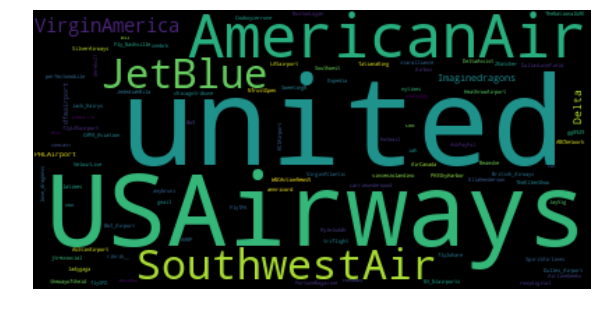

In [21]:
from wordcloud import WordCloud
at_cloud = WordCloud(collocations=False).generate(all_mentions_str)
plt.figure(figsize=(10,10) )
plt.imshow(at_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
at_and_text_tokenizer = RegexpTokenizer("[\w+'-]+")
removed_links = tweets.text.str.replace(r'http\S+', 'link')
at_and_texted = removed_links.map(lambda t: at_and_text_tokenizer.tokenize(t))
all_tweet_str = ' '.join([' '.join(at_and_texted.values[i]) for i in range(at_and_texted.shape[0])])
all_tweet_str = re.sub(r"@", "", all_tweet_str)

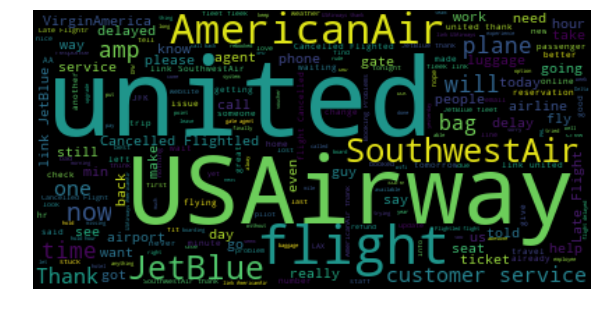

In [23]:
text_cloud = WordCloud().generate(all_tweet_str)
plt.figure(figsize=(10,10) )
plt.imshow(text_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
stopwords = stopwords.union(set(['AmericanAir', 'United', 'USAirways', 'JetBlue', 'SouthwestAir', 'Delta', 'VirginAmerica']))

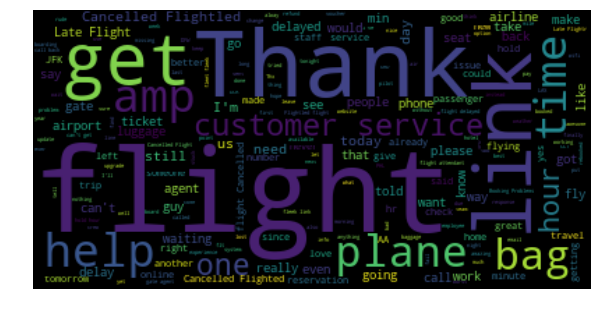

In [25]:
text_cloud = WordCloud(stopwords=stopwords).generate(all_tweet_str)
plt.figure(figsize=(10,10) )
plt.imshow(text_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

While looking at items in `text_cloud.words_`, I noticed that there were some things that needed to be cleaned, for example the phrase "Late Flightr" shows up reasonably often... 

In [26]:
text_cloud.words_['Late Flightr']

0.06914660831509847

In [27]:
text_cloud.words_['Late Flight']

0.10897155361050329

In [28]:
print(tweets.text.where(tweets.text.str.contains('Late Flightr')).dropna()[539])

@united See? We were told repeatedly that the pilot was Late Flight and kept getting Late Flightr.  After we boarded, there was a defibrillator issue.


It turns out that the text of this tweet has been post-processed: the text of the original tweet is: 
> @united See? We were told repeatedly that the pilot was late and kept getting later. After we boarded, there was a defibrillator issue.

It looks like "late" may sometimes be replaced with "Late Flight". This probably occurred during post-processing/ sentiment analysis. We notice that the`negativereason` field is filled out for this entry.

In [29]:
tweets.iloc[539]

tweet_id                                                       570289777184002048
airline_sentiment                                                        negative
airline_sentiment_confidence                                                    1
negativereason                                                        Late Flight
negativereason_confidence                                                  0.6624
airline                                                                    United
airline_sentiment_gold                                                        NaN
name                                                                BocheBillions
negativereason_gold                                                           NaN
retweet_count                                                                   0
text                            @united See? We were told repeatedly that the ...
tweet_coord                                                                   NaN
tweet_created   

"Cancelled Flightled" is another funny phrase that shows up. 

In [30]:
tweets.iloc[129].text

'@VirginAmerica is flight 882 Cancelled Flightled and what do I do if it is?'

The original tweet reads 
> @VirginAmerica is flight 882 cancelled and what do I do if it is?

In [31]:
tweets.iloc[129].negativereason

nan

In this case the sentiment of the tweet was deemed neutral and so there's no negative reason. So probably all text is postprocessed, not just when the sentiment was detected to be negative. 

## Basic sentiment analysis with scikit-learn 

Let's process the data slightly differently: replace links with "link", remove emojis, remove @s but not handles, remove #s but not the tags themselves take out stopwords. 

In [32]:
S = tweets.text.str.replace(r'http\S+', 'link') #replace links 
unicode_emoji_ranges= ['[\U0001f300-\U0001f5fF]',
                        '[\U0001f600-\U0001f64F]',
                        '[\U0001f680-\U0001f6FF]',
                        '[\U00002600-\U000026FF]',
                        '[\U00002700-\U000027BF]']
for emojis in unicode_emoji_ranges: 
    S = S.str.replace(emojis, '')
S = S.str.replace(r"@", "")
S = S.str.replace(r"#", "")
S = S.map(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [33]:
S.head()

0                                  What dhepburn said.
1          plus added commercials experience... tacky.
2       I today... Must mean I need take another trip!
3    really aggressive blast obnoxious "entertainme...
4                                 really big bad thing
Name: text, dtype: object

We can use the sentiment analysis performed by Crowdflower to transform this into a supervised learning problem, at least for now.

Note that the sentiment they record is the airline_sentiment. 

In [34]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
labels = enc.fit_transform(tweets.airline_sentiment).reshape(-1,1)
count_vect = CountVectorizer()
tweets_vect = count_vect.fit_transform(S.values)
X_train, X_test, y_train, y_test = train_test_split(tweets_vect, labels, test_size = .25)

In [36]:
from sklearn.naive_bayes import MultinomialNB

sentiment_classifier = MultinomialNB().fit(X_train, y_train)

/conda/envs/nlp/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# notes from last call

EDA/ Statistical inference/ Find a problem/ then do the ML

maybe shallow NN, but let's see 

Word frequencies, actual words, acronyms, hashtags, emojis (statistics, how many tweets have them) 
term frequency
inverse document frequency
identifying stopwords in nontraditional corpuses (TF-IDF)

word vectors, sentence vectors --> visualize, grouping phrases

In [35]:
import twitter
# CONSUMER_KEY, etc are private, you can get your own 
# if you sign up for a twitter developer acct. 
api = twitter.Api(consumer_key=CONSUMER_KEY,
                      consumer_secret=CONSUMER_SECRET,
                      access_token_key=ACCESS_TOKEN,
                      access_token_secret=ACCESS_TOKEN_SECRET, 
                      sleep_on_rate_limit=True)

In [43]:
original_tweet_text = tweets[['tweet_id']]
original_tweet_text = original_tweet_text.set_index('tweet_id')
original_tweet_text['text'] = ''

In [46]:
import time 
start_time = time.monotonic()
for rng in range(100, original_tweet_text.shape[0]):
    if rng % 1000 == 0: 
        print(rng, time.monotonic() - start_time)
    input_list = list(original_tweet_text.index[rng - 100: rng])
    request_out = api.GetStatuses(input_list)
    for status in request_out:
        original_tweet_text.loc[status.id, 'text'] = status.text
end_time = time.monotonic()
elapsed_time = end_time - start_time 
print(elapsed_time/3600)
original_tweet_text.to_csv('original_tweets.csv')

1000 643.9835037960002
2000 1585.8188834270002
3000 2527.7738708819998
4000 3469.4478770759997
5000 4414.160346271
6000 5353.431650677
7000 6303.905091482
8000 7286.439423401
9000 8183.197645733
10000 9734.462748335
11000 10676.116390371
12000 11633.363547891
13000 12563.556167749
14000 13520.510916573
3.9802069880352775


In [37]:
original_tweet = pd.read_csv('original_tweets.csv')

In [42]:
original_tweet.head()

,tweet_id,text
0,570306133677760513,@VirginAmerica What @dhepburn said.
1,570301130888122368,@VirginAmerica plus you've added commercials t...
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,@VirginAmerica and it's a really big bad thing...


There are 3191 missing tweets. Not surprising as the tweets were collected in 2015. 

In [200]:
original_tweet[original_tweet.text.isna()].shape

(3191, 2)

While merging, I noticed that there must be a problem with nonunique `tweet_id`

In [46]:
tweets.merge(original_tweet).shape

(10417, 15)

In [82]:
tweets.shape

(14604, 15)

In [98]:
no_appear = tweets.tweet_id.value_counts()
duplicate_tweets = no_appear.where(no_appear > 1).dropna()
df_duplicate = tweets[tweets.tweet_id.isin(duplicate_tweets.index)].sort_values(by='tweet_id')
duplicate_ids = list(duplicate_tweets.index)

155 tweets are recorded more than once 

In [99]:
duplicate_tweets.shape

(155,)

In [100]:
df_duplicate.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12033,569600137296633856,positive,0.9236,NaN,0.0000,American,positive,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30-08:00,"Caribbean, New York and Miami.",Indiana (East)
14556,569600137296633856,positive,1.0000,NaN,NaN,American,NaN,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30-08:00,"Caribbean, New York and Miami.",Indiana (East)
14543,569601363799359488,negative,1.0000,Flight Attendant Complaints,1.0000,American,NaN,stevereasnors,NaN,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22-08:00,Los Angeles,Pacific Time (US & Canada)
12032,569601363799359488,negative,0.9553,Flight Attendant Complaints,0.9553,American,negative,stevereasnors,Flight Attendant Complaints,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22-08:00,Los Angeles,Pacific Time (US & Canada)
12031,569621879633391616,negative,1.0000,Customer Service Issue,1.0000,American,negative,salitron78,Customer Service Issue,0,@AmericanAir no response to DM or email yet. ...,NaN,2015-02-22 14:16:53-08:00,on @TheJR,Seoul


It's a bit hard to tell what went on with these tweets but the sentiment confidence values can be different for the same tweet (in fact, they often are). 
What we care about the most are the positive/negative/neutral labels for airline sentiment. So for now, my solution is to aggregate the entries. For the sentiment_confidence and reason_confidence values, we'll take the mean. For negative reason we'll take a join so that we don't lose information. 

We'll refactor the duplicates, drop from tweets, and then concatenate the fixed entries. 

For the ones with two different sentiment labels we'll have to decide what to do:

In [101]:
no_different_sentiments = df_duplicate.groupby('tweet_id').airline_sentiment.apply(set).apply(len)
print(no_different_sentiments.where(no_different_sentiments > 1).dropna().shape)
drop_list = list(no_different_sentiments.where(no_different_sentiments > 1).dropna().index)

(18,)


There are only 18 such tweets. For now I will just drop them completely. We'll do that first (note: this means we are removing 36 rows) 

In [102]:
df_duplicate.shape

(310, 15)

In [103]:
df_duplicate = df_duplicate[~df_duplicate.tweet_id.isin(drop_list)]
print(df_duplicate.shape)

(274, 15)


For the rest we want to transform the sub-dfs we get into one row each

In [143]:
df_duplicate.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [186]:
def combine_duplicate_tweets(one_tweet_df): 
    row_dict = {}
    for col_name in ['tweet_id', 'airline_sentiment']:
        row_dict[col_name] = one_tweet_df[col_name].iloc[0]
    row_dict['airline_sentiment_confidence'] =  one_tweet_df['airline_sentiment_confidence'].mean()
    neg_reasons = set(one_tweet_df['negativereason'].values)
    neg_reasons = [reason for reason in neg_reasons if type(reason) == str]
    if not neg_reasons: 
        row_dict['negativereason'] = np.nan
    else:
        row_dict['negativereason'] = ', '.join(neg_reasons)
    row_dict['negativereason_confidence'] = np.nanmean(one_tweet_df['negativereason_confidence'])
    row_dict['airline'] = one_tweet_df['airline'].iloc[0]
    airline_sentiment_gold = [sentiment for sentiment in one_tweet_df.airline_sentiment_gold.values
                             if type(sentiment) == str]
    row_dict['airline_sentiment_gold'] = ', '.join(airline_sentiment_gold)
    row_dict['name'] = one_tweet_df['name'].iloc[0]
    negativereason_gold = [reason for reason in one_tweet_df['negativereason_gold'].values
                             if type(reason) == str]
    row_dict['negativereason_gold'] = ', '.join(negativereason_gold)
    for col_name in ['retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 
                    'user_timezone']:
        row_dict[col_name] = one_tweet_df[col_name].iloc[0]
    return pd.DataFrame.from_dict(row_dict, orient='index').T

In [187]:
refactored_duplicates = df_duplicate.groupby('tweet_id').apply(combine_duplicate_tweets)
refactored_duplicates = refactored_duplicates.droplevel(level=0).reset_index().drop('index', axis=1)

/conda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


In [188]:
tweets = tweets.loc[~tweets.tweet_id.isin(duplicate_ids)]

In [193]:
tweets = pd.concat([tweets, refactored_duplicates], axis = 0, ignore_index = True)

In [194]:
len(tweet_test.tweet_id.unique()) ==  tweet_test.tweet_id.shape[0]

True

In [202]:
original_tweet = original_tweet.groupby('tweet_id').first().reset_index()

In [207]:
tweets_with_originals = tweets.merge(original_tweet, on = 'tweet_id', suffixes = ['_proc', '_orig'])

In [214]:
tweets_with_originals.to_csv('tweets_with_originals.csv', index=False)

Next task: deal with tweets where original is no longer available